# Parte 2: Trabajando con el problema de arranque en frio de filtrado basado en contenido (Content-Based Filtering)

El `filtrado colaborativo` se basa en las interacciones del usuario con los items (user-item) dentro de una matriz de utilidad. El problema reside en que los nuevos usuarios o los elementos que no cuenten con interacciones registradas van a ser ignoradas por el sistema de recomendacion. A esto se le conoce como el problema de "Arranque en frio". El filtrado basado en contenido es una manera de atacar este problema al generar recomendaciones en interacciones usuario-item.

En el siguiente ejercicio, generaremos recomendaciones tipo item-item utilizando filtrado basado en contenido.

### Paso 1: Importar las librerias necesarias

Se utiizaran los siguientes paquetes de Python:

- [numpy](https://numpy.org/): para calculos cientificos
- [pandas](https://pandas.pydata.org/): para manipulacion de dato
- [scikit-learn](https://scikit-learn.org/stable/): para funciones de machine learning 
- [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/): para visualizacion de datos

In [40]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process

### Paso 2: Cargando los datos

Construiremos nuestro sistema de recomendacion a partir del supuesto de que conocemos muy poco acerca de nuestros usuarios. No contamos con datos suficientes sobre las interacciones con nuestro sistema como para implementar filtrado colaborativo.

Exploremos el dataset para conocer su estructura y las propiedades con las que podemos trabajar.

In [41]:
#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('u.item', sep='|', names=i_cols, encoding='latin-1')
items.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Paso 3: Limpieza y Exploracion de los Datos

Para este dataset en particular, debemos de limpiar los datos partiendo de las dos siguientes consideraciones:

1. Los generos de las peliculas estan expresados en un string separados por un pipe | . Debemos manipular este string en una lista que nos facilitara el analisis de los datos.
2. El Titulo tiene el año en la que la pelicula fue proyectada. Necesitamos en este caso tambien, extraer el titulo de la pelicula y crear una nueva columna para almacenar este campo.

Ahora cambiamos el orden de las columnas donde se cambiará el valor 1 por cada colum ade los géneros del cine por el texto del género y se unificará en una única columna

#### Transformando los Generos de un String a una lista


Utilizaremos la funcion "split" para separar los generos de la columna con el mismo nombre. 

Por lo que convertiremos este string:

`"Adventure|Children|Fantasy"`

En un arreglo como este:
`[Adventure, Children, Fantasy]`.

In [42]:
for column in items[['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']].columns:
    items[column] = items[column].apply(lambda x: column if x == 1 else str(x) )

items['genres'] = items[['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']].values.tolist()
items['genres'] = items['genres'].apply(lambda x: [i for i in x if i[0] not in '0'] )

In [43]:
# Eliminamos las columnas sobrantes
items.drop(columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], inplace=True)

In [44]:
items.shape

(1682, 6)

In [45]:
items.head()

,movie id,movie title,release date,video release date,IMDb URL,genres
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,"[Action, Adventure, Thriller]"
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,[Thriller]
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,"[Action, Comedy, Drama]"
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),"[Crime, Drama, Thriller]"


#### Calculemos cuantos generos de peliculas contiene el dataset?

Al utilizar la funcion de conteo de Python podemos crear un diccionario que contenga el conteo de frecuencias para cada genero en el dataset.

In [46]:
contador_generos = Counter(g for genres in items['genres'] for g in genres)
print(f"Existen {len(contador_generos)} tipos de generos.")
contador_generos

Existen 19 tipos de generos.


Counter({'Drama': 725,
         'Comedy': 505,
         'Action': 251,
         'Thriller': 251,
         'Romance': 247,
         'Adventure': 135,
         "Children's": 122,
         'Crime': 109,
         'Sci-Fi': 101,
         'Horror': 92,
         'War': 71,
         'Mystery': 61,
         'Musical': 56,
         'Documentary': 50,
         'Animation': 42,
         'Western': 27,
         'Film-Noir': 24,
         'Fantasy': 22,
         'unknown': 2})

Existen 20 diferentes etiquetas para los generos y 19 generos asignados a las peliculas de este dataset. Algunas peliculas no contienen un genero asignado y es por ello que existe la etiqueta `(no genres listed)`. 


In [47]:
movies = items[items['genres']!='(no genres listed)']
del contador_generos['(no genres listed)']

#### Cuales son los generos de peliculas mas comunes?

Utilizaremos el metodo mas comun de `Counter` que es `most_common()` para obtener el listado de generos con asociados a la mayor cantidad de peliculas.

In [48]:
print("Top 10 de generos de peliculas: \n", contador_generos.most_common(10))

Top 10 de generos de peliculas: 
 [('Drama', 725), ('Comedy', 505), ('Action', 251), ('Thriller', 251), ('Romance', 247), ('Adventure', 135), ("Children's", 122), ('Crime', 109), ('Sci-Fi', 101), ('Horror', 92)]


En el Top 10 de generos encontramos: `Drama`, `Comedia`, `Thriller`, `Accion`,`Romance`, `Aventura`, `Crimen`, `Terror`, `Ciencia Ficcion` y `Fantasia`. 

Utilizemos barplot para visualizar esta informacion.

/tmp/ipykernel_369647/753039935.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genres', y='count', data=genres_counts_df, palette='rocket')


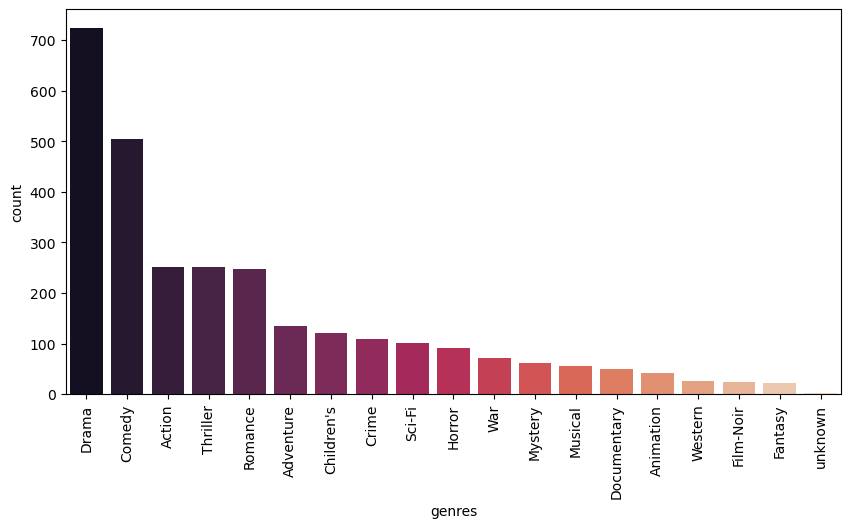

In [49]:
genres_counts_df = pd.DataFrame([contador_generos]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()

La grafica nos confirma lo que descubrimos anteriormente, `Drama` y `Comedia` son los generos mas populares mientras que los `Westerns`, `IMAX`, and `Film-Noir` son los menos populares.

#### Extrayendo el año del titulo de las peliculas

Como lo mencionamos al inicio, nuestro dataset contiene en parentesis el año junto con el titulo de la pelicula, c.p.e GoldenEye (1995). Luego entonces, queremos utilizar el año de una pelicula como una caracteristica de las peliculas por lo que lo extrearemos del titulo y crearemos una columna `year` para almacenar este dato.


La siguiente funcion lleva a cabo esta tarea.
`extraer_año_titulo_pelicula()` toma el titulo y hace lo siguiente:

- genera una lista al dividir cada palabra con espacios (e.g., `["Golden", "Eye", "(1995)"]`)
- toma el ultimo elemento de la lista (e.g., `"(1995)"`)
- Si el elemento tiene parentesis `()` alrededor, estos se remueven(e.g., `"1995"`)
- convierte el año en un entero

In [50]:
def extraer_año_titulo_pelicula(title):
    t = title.split(' ')
    year = None
    if re.search(r'\(\d+\)', t[-1]):
        year = t[-1].strip('()')
        year = int(year)
    return year

Podemos validar esta funcion con la pelicula `"Golden Eye (1995)"`:

In [51]:
title = "Golden Eye (1995)"
year = extraer_año_titulo_pelicula(title)
print(f"La pelicula {title} se estreno el año de {year}") 
type(year)

La pelicula Golden Eye (1995) se estreno el año de 1995


int

La funcion `extract_year_from_title()` permite extraer el año del string por lo que ahora podemos aplicar esta funcion a todo el data frame de `movies` utilizando el metodo `apply ()` de Pandas.

In [52]:
items['year'] = items['movie title'].apply(extraer_año_titulo_pelicula)
items.head()

,movie id,movie title,release date,video release date,IMDb URL,genres,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"[Animation, Children's, Comedy]",1995.0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,"[Action, Adventure, Thriller]",1995.0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,[Thriller],1995.0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,"[Action, Comedy, Drama]",1995.0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),"[Crime, Drama, Thriller]",1995.0


#### Cuantos año distintos estan contenidos en nuestro dataset?


In [53]:
unique_years = items['year'].nunique()
print(f"Total de años distintos en nuestro dataset: {unique_years}")

Total de años distintos en nuestro dataset: 71


Con este calculo rapido, nos percatamos que contamos con mas de 100 años en nuestro dataset. Lo que podemos hacer ahora es dividir nuestros datos en decadas para tener una idea en general de cuando fueron lanzadas las peliculas de nuestro dataset.

#### Cual fue la decada mas popular para estrenar una pelicula?

Analizemos el dataset para conocer el numero de peliculas contenidas.

In [54]:
print(f"Numero total de peliculas en el dataset: {items['movie id'].nunique()}")

Numero total de peliculas en el dataset: 1682


Ahora limpiemos nuestro dataset al eliminar todas las peliculas que contengan un `null` en el año.

In [55]:
items = items[~items['year'].isnull()]
print(f"Total de peliculas despues de eliminar aquellas con null en el año:: {items['movie id'].nunique()}")

Total de peliculas despues de eliminar aquellas con null en el año:: 1677


Esto nos dice que se eliminaron 24 peliculas que no contaba con un año de lanzamiento:

Existen dos formas de calcular la decada de un año:

1. convertir el año a string y remplazar el ultimo digito con un 0

2. redondear el año al decimo (10) proximo

In [56]:
x = 1995

def calcular_decada(year):
    year = str(year)
    decade_prefix = year[0:3] # obtener los primeros 3 digitos de un año
    decade = f'{decade_prefix}0' # añadir un 0 al final
    return int(decade)

calcular_decada(x)

1990

In [57]:
def redondear(year):
    return year - (year%10)

redondear(x)

1990

Ambas funciones `calcular_decada()` y `redondear()` cumplen con el objetivo de identificar la decada de un año.

Podemos aplicar cualquiera de ellas a todos los años de nuestro dataset `movies` y al mismo tiempo crearemos una columna llamada `decade`.


In [58]:
items['decade'] = items['year'].apply(redondear)

### Paso 4: Transformando los datos

Para construir un sistema de recomendacion con filtrado basado en contenido necesitamos preparar nuestro dataset de forma tal que las filas representen las peliculas y las columnas las caracteristicas (generos y decadas)


Primero, debemos manipular la columna de `generos` de forma tal que cada genero sea representado por una caracteristica binaria (1 si pertenece a un determinado genero, 0 si no pertenece)

In [59]:
genres = list(contador_generos.keys())

for g in genres:
    items[g] = items['genres'].transform(lambda x: int(g in x))

Analizando la estructura de los datos se desplieguan de la siguiente manera:

In [60]:
items[genres].head()

,Animation,Children's,Comedy,Action,Adventure,Thriller,Drama,Crime,Sci-Fi,War,Romance,Horror,Musical,Documentary,Western,Fantasy,Film-Noir,Mystery,unknown
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0


Con esto comprobamos que los generos se representan como columnas con propiedades binarias. Ahora debemos asignar las distintas decadas a sus columnas correspondientes. Lo realizamos al utilizar la funcion `get_dummies()` de `pandas` al crear variables categoricas en variables binarias.

In [61]:
movie_decades = pd.get_dummies(items['decade'])
movie_decades.head()

,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0
0,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,True


Lo siguiente es crear un nuevo dataframe con las propiedades de de decada y genero de las peliculas en `movie_features`. Lo conseguimos al utilizar la funcion `concat` de pandas, al concatenar los generos y las decadas en un solo dataframe.

In [62]:
movie_features = pd.concat([items[genres], movie_decades], axis=1)
movie_features.head()

,Animation,Children's,Comedy,Action,Adventure,Thriller,Drama,Crime,Sci-Fi,War,...,Mystery,unknown,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0
0,1,1,1,0,0,0,0,0,0,0,...,0,0,False,False,False,False,False,False,False,True
1,0,0,0,1,1,1,0,0,0,0,...,0,0,False,False,False,False,False,False,False,True
2,0,0,0,0,0,1,0,0,0,0,...,0,0,False,False,False,False,False,False,False,True
3,0,0,1,1,0,0,1,0,0,0,...,0,0,False,False,False,False,False,False,False,True
4,0,0,0,0,0,1,1,1,0,0,...,0,0,False,False,False,False,False,False,False,True


El dataframe `movie_features` esta listo y contiene los datos que nos interesan. Ahora debemos de construir nuestro sistema de recomendacion.

### Step 5: Construyendo un sistema de recomendacion de "Peliculas Parecidas" utilizando similitud Coseno

Para construir este sistema de recomendacion item-item utilizaremos una metrica llamada similitud coseno `cosine similarity`.

La similitud Coseno se basa en el coseno del angulo entre dos vectores (c.e., $A$ y $B$). Entre mas pequeño es el angulo, mayor es la similitud entre los vectores, y se calcula de la siguiente forma:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

En este ejercicio, utilizaremos la funcion de scikit-learn de `cosine_similarity` para generar la matriz de similitud de tipo $(n_{\text{movies}}, n_{\text{movies}})$. Esta matriz nos permitira extraer peliculas que sean parecidas a nuestra pelicula de interes.

In [63]:
cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {cosine_sim.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (1677, 1677)


Esto nos indica que al evaluar la similitud de coseno del dataframe `movie_features` en la funcion `cosine_similarity()` obtenemos una matriz de similitud del tipo $(n_{\text{movies}}, n_{\text{movies}})$.

Esta matriz contiene valores entre 0 y 1 que representan el angulo de similaridad entre las peliculas en los ejes x , y.


### Desarrollando una funcion que encuentre peliculas similares

Si por ejemplo queremos encontrar peliculas que sean similares a `Jumanji` en nuestro sistema de recomendacion, necesitamos saber el titulo de una pelicula en nuestro dataset.

Afortunadamente la pelicula esta listada como `'Jumanji (1995)'`. Sin embargo, si deletreamos mal el nombre u olvidamos incluir el año de su lanzamiento, el sistema no sabra que pelicula es a la que nos estamos refiriendo.

Con el fin de que nuestro sistema sea mas amigable para el usuario, utilizaremos un paquete llamado `fuzzywuzzy` que nos ayudara a encontrar el titulo de la pelicula mas parecido a partir del string que le pasemos. 

Con base en esto, crearemos una funcion que se llame `encuentra_pelicula()` que implementa el algoritmo de matching de strings de `fuzzywuzzy` para hallar el titulo mas parecido a partir de un string ingresado por el usuario.

In [64]:
def encuentra_pelicula(title):
    all_titles = items['movie title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

Probemos la funcionalidad de la funcion `encuentra_pelicula()` al escribir equivocadamente la pelicula `Jumanji`

In [65]:
title = encuentra_pelicula('Star w')
print(f"El titulo correcto de la pelicula es: {title}:")

El titulo correcto de la pelicula es: Star Wars (1977):


Ahora que ya no nos preocupamos por escribir mal el titulo de una pelicula, lo que nos interesa es encontrar recomendaciones relevantes a partir de la pelicula que deseamos.

Deseamos encontrar el indice de la pelicula en la matriz de similitud coseno. Para identificar la fila en la cual debemos buscar podemos crear un mapeador de indices de peliculas que encuentre el titulo de una pelicula y le asigne el indice que representa en nuestra matriz.

Crearemos un diccionario llamado `movie_idx` donde las llaves son los titulos de las peliculas y los valores son los indices de las peliculas.

In [66]:
movie_idx = dict(zip(items['movie title'], list(movies.index)))
idx = movie_idx[title]
print(f"El indice de la pelicula {title} en la matriz movie_idx es: {idx}")

El indice de la pelicula Star Wars (1977) en la matriz movie_idx es: 49


Al usar el diccionario `movie_idx`, sabemos que Jumanji se representa por el indice 1 en nuestra matriz. 

Ahora tratemos de encontrar las 10 peliculas mas similares a Jumanji.

In [67]:
numero_recomendaciones=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(numero_recomendaciones+1)]
similar_movies = [i[0] for i in sim_scores]

`similar_movies` es un arreglo de indices que representa el top 10 de recomendaciones a partir de la pelicula elegida (en este caso Jumanji). Podemos encontrar el titulos de las peliculas correspondientes al crear un mapeador invertido de `movie_idx` o usando `iloc` en la columna de titulo del dataframe `movies`.

In [68]:
print(f"Por que miraste la pelicula {title}, te pueden interesar las siguientes {numero_recomendaciones} peliculas:")
items['movie title'].iloc[similar_movies]

Por que miraste la pelicula Star Wars (1977), te pueden interesar las siguientes 10 peliculas:


180                        Return of the Jedi (1983)
448             Star Trek: The Motion Picture (1979)
171                  Empire Strikes Back, The (1980)
270                         Starship Troopers (1997)
497                        African Queen, The (1951)
61                                   Stargate (1994)
81                              Jurassic Park (1993)
120                    Independence Day (ID4) (1996)
221                  Star Trek: First Contact (1996)
226    Star Trek VI: The Undiscovered Country (1991)
Name: movie title, dtype: object

Podemos probar nuestro sistema con otros titulos de peliculas. 

In [69]:
def obtener_recomendaciones_basadas_contenido(title_string, numero_recomendaciones=10):
    title = encuentra_pelicula(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(numero_recomendaciones+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Las peliculas recomendadas con base en la pelicula {title} son:")
    print(items['movie title'].iloc[similar_movies])

In [71]:
obtener_recomendaciones_basadas_contenido('Star Wars', 5)

Las peliculas recomendadas con base en la pelicula Star Wars (1977) son:
180               Return of the Jedi (1983)
448    Star Trek: The Motion Picture (1979)
171         Empire Strikes Back, The (1980)
270                Starship Troopers (1997)
497               African Queen, The (1951)
Name: movie title, dtype: object


# Recomendaciones finales:

## Repite todos los pasos contenidos en este proyecto con el dataset de tu proyecto.